In [1]:
import os
import pandas as pd
import yaml
import torch
import collections

import warnings
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

warnings.filterwarnings("ignore")

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_20176\3482666853.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def process_experiment(root_dir):
    rows = []

    for name in os.listdir(root_dir):
        experiment_path = os.path.join(root_dir, name)
        if os.path.isdir(experiment_path):
            for seed_name in os.listdir(experiment_path):
                seed_path = os.path.join(experiment_path, seed_name)
                if os.path.isdir(seed_path):
                    row_data = process_subexperiment(
                        seed_path, os.path.basename(root_dir)
                    )
                    for data in row_data:
                        data["seed"] = seed_name
                        data["experiment_name"] = name
                        data["sub_experiment_path"] = seed_path
                    rows.extend(row_data)  

    # Create a DataFrame from the rows
    df = pd.DataFrame(rows)
    return df


def process_subexperiment(seed_folder_path, experiment_name):
    cfg_data = read_config(os.path.join(seed_folder_path, "cfg.yaml"), experiment_name)
    cfg_data["sub_experiment_path"] = seed_folder_path 
    train_stats_file = find_train_stats_file(seed_folder_path)
    if train_stats_file:
        experiment_results = process_training_stats(
            train_stats_file, cfg_data
        )
        return experiment_results
    else:
        return []  # Return an empty list if no train stats file is found


def read_config(cfg_path, experiment_name):
    with open(cfg_path, "r") as file:
        config = yaml.safe_load(file)
        full_title = config.get("full_title", "")
        variable_part = remove_experiment_name(full_title, experiment_name)
        return parse_config_variables(variable_part)


def remove_experiment_name(full_title, experiment_name):
    to_remove = experiment_name + "_"
    return (
        full_title[len(to_remove) :].strip()
        if full_title.startswith(to_remove)
        else full_title
    )


def parse_config_variables(variable_str):
    variables = {}
    for part in variable_str.split(";"):
        if "=" in part:
            key, value = part.split("=", 1)
            key = f"sub_exp_cfg_{key.strip()}"  # Add prefix
            variables[key] = value.strip()
    return variables


def find_train_stats_file(folder_path):
    for file in os.listdir(folder_path):
        if file.endswith("_train_stats"):
            return os.path.join(folder_path, file)
    return None


def process_training_stats(train_stats_file, cfg_data):
    checkpoint = torch.load(train_stats_file)

    training_stats = checkpoint.get("training_stats", [])
    validation_stats = checkpoint.get("validation_stats", [])
    redo_stats = checkpoint.get("redo_scores", [])

    stats_records = process_stats(training_stats, cfg_data, "training") + process_stats(
        validation_stats, cfg_data, "validation"
    )

    # Combine stats records with redo scores
    combined_records = []
    for record in stats_records:
        combined_record = record.copy()  # Copy the stats record
        combined_records.append(combined_record)

    return combined_records


def process_stats(stats, cfg_data, stats_type):
    records = []
    for epoch_stats in stats:
        record = {"epoch_type": stats_type}
        record.update(flatten(epoch_stats))  # Flatten the epoch_stats if it's nested
        record.update(cfg_data)  # Add configuration data
        records.append(record)
    return records


def flatten(d, parent_key="", sep="_"):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.abc.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [3]:
experiment_sub_dir = "2025Apr18-172710_configs"
exp_path = os.path.join(r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results", experiment_sub_dir)
df = process_experiment(
    exp_path
)
df.columns


Index(['epoch_type', 'frame_stamp', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_discounted_rewards_min',
       'episode_discounted_rewards_max', 'episode_discounted_rewards_mean',
       'episode_discounted_rewards_median', 'episode_discounted_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_losses_min',
       'episode_losses_max', 'episode_losses_mean', 'episode_losses_median',
       'episode_losses_std', 'episode_max_qs_min', 'episode_max_qs_max',
       'episode_max_qs_mean', 'episode_max_qs_median', 'episode_max_qs_std',
       'policy_trained_times', 'target_trained_times', 'epoch_time',
       'sub_exp_cfg_agent_params.args_.action_w_noise_amplitude',
       'sub_experiment_path', 'seed', 'experiment_name'],
      dtype='object')

In [4]:
df

,epoch_type,frame_stamp,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,episode_discounted_rewards_mean,...,episode_max_qs_mean,episode_max_qs_median,episode_max_qs_std,policy_trained_times,target_trained_times,epoch_time,sub_exp_cfg_agent_params.args_.action_w_noise_amplitude,sub_experiment_path,seed,experiment_name
0,training,200000,-68.420674,-54.716895,-65.604211,-65.588838,2.493046e+00,-6.987261,-6.685935,-6.942251,...,-0.496464,-0.491837,0.221571,24374.0,48.0,0 days 00:02:09.161351,0,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
1,training,400000,-67.892147,-46.497350,-55.394007,-52.554506,6.580515e+00,-6.983187,-6.565829,-6.780376,...,-0.871266,-0.877041,0.152283,25000.0,48.0,0 days 00:02:15.391167,0,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
2,training,600000,-55.667726,-46.971203,-52.898388,-53.202165,1.314633e+00,-6.744280,-6.545769,-6.663480,...,-1.042947,-1.029223,0.194919,25000.0,48.0,0 days 00:02:21.272295,0,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
3,training,800000,-55.312390,-42.316068,-48.701482,-49.448653,3.395440e+00,-6.703618,-6.268364,-6.481069,...,-1.051107,-1.024510,0.218154,25000.0,48.0,0 days 00:02:21.221650,0,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
4,training,1000000,-45.771627,-40.142415,-43.052072,-43.041092,1.161139e+00,-6.370803,-6.200634,-6.290408,...,-0.974054,-0.913624,0.242427,25000.0,56.0,0 days 00:02:21.696604,0,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,validation,3200000,-1.453559,-1.453559,-1.453559,-1.453559,4.440892e-16,-1.324021,-1.324021,-1.324021,...,2864.683757,3015.943359,795.925229,NaN,NaN,0 days 00:00:00.354809,0.9,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0004_agent_params.args_.action_w_noise_amplitu...
196,validation,3400000,-1.453559,-1.453559,-1.453559,-1.453559,4.440892e-16,-1.324021,-1.324021,-1.324021,...,1954.671631,2070.780884,535.190370,NaN,NaN,0 days 00:00:00.378377,0.9,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0004_agent_params.args_.action_w_noise_amplitu...
197,validation,3600000,-1.453559,-1.453559,-1.453559,-1.453559,4.440892e-16,-1.324021,-1.324021,-1.324021,...,1320.608765,1382.066162,362.005159,NaN,NaN,0 days 00:00:00.367180,0.9,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0004_agent_params.args_.action_w_noise_amplitu...
198,validation,3800000,-1.453559,-1.453559,-1.453559,-1.453559,4.440892e-16,-1.324021,-1.324021,-1.324021,...,1021.165273,1078.268768,260.855128,NaN,NaN,0 days 00:00:00.361593,0.9,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0004_agent_params.args_.action_w_noise_amplitu...


In [5]:
# normalize rewards?

In [6]:
df[df['epoch_type'] == 'validation']

,epoch_type,frame_stamp,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,episode_discounted_rewards_mean,...,episode_max_qs_mean,episode_max_qs_median,episode_max_qs_std,policy_trained_times,target_trained_times,epoch_time,sub_exp_cfg_agent_params.args_.action_w_noise_amplitude,sub_experiment_path,seed,experiment_name
20,validation,200000,-67.853052,-67.853052,-67.853052,-67.853052,0.000000e+00,-6.982947,-6.982947,-6.982947,...,-0.892352,-0.889138,0.010237,NaN,NaN,0 days 00:00:00.386013,0,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
21,validation,400000,-50.598977,-50.598977,-50.598977,-50.598977,0.000000e+00,-6.651243,-6.651243,-6.651243,...,-0.929529,-0.908738,0.196446,NaN,NaN,0 days 00:00:00.375495,0,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
22,validation,600000,-54.878416,-54.878416,-54.878416,-54.878416,0.000000e+00,-6.692977,-6.692977,-6.692977,...,-1.145025,-1.130663,0.172268,NaN,NaN,0 days 00:00:00.382096,0,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
23,validation,800000,-42.562390,-42.562390,-42.562390,-42.562390,0.000000e+00,-6.274751,-6.274751,-6.274751,...,-0.954242,-0.886473,0.237746,NaN,NaN,0 days 00:00:00.386205,0,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
24,validation,1000000,-43.479153,-43.479153,-43.479153,-43.479153,0.000000e+00,-6.302914,-6.302914,-6.302914,...,-0.989183,-0.933051,0.243262,NaN,NaN,0 days 00:00:00.375820,0,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_agent_params.args_.action_w_noise_amplitu...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,validation,3200000,-1.453559,-1.453559,-1.453559,-1.453559,4.440892e-16,-1.324021,-1.324021,-1.324021,...,2864.683757,3015.943359,795.925229,NaN,NaN,0 days 00:00:00.354809,0.9,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0004_agent_params.args_.action_w_noise_amplitu...
196,validation,3400000,-1.453559,-1.453559,-1.453559,-1.453559,4.440892e-16,-1.324021,-1.324021,-1.324021,...,1954.671631,2070.780884,535.190370,NaN,NaN,0 days 00:00:00.378377,0.9,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0004_agent_params.args_.action_w_noise_amplitu...
197,validation,3600000,-1.453559,-1.453559,-1.453559,-1.453559,4.440892e-16,-1.324021,-1.324021,-1.324021,...,1320.608765,1382.066162,362.005159,NaN,NaN,0 days 00:00:00.367180,0.9,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0004_agent_params.args_.action_w_noise_amplitu...
198,validation,3800000,-1.453559,-1.453559,-1.453559,-1.453559,4.440892e-16,-1.324021,-1.324021,-1.324021,...,1021.165273,1078.268768,260.855128,NaN,NaN,0 days 00:00:00.361593,0.9,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0004_agent_params.args_.action_w_noise_amplitu...


In [7]:
# Define hyperparameter columns
hyperparam_columns = [col for col in df.columns if "sub_exp_cfg" in col]

# Group by hyperparameter values and compute mean episode_rewards_mean
averaged_results = df.groupby(hyperparam_columns, as_index=False).agg({
    'episode_rewards_mean': 'mean',  # Averaging the performance metric
    'sub_experiment_path': 'first'   # Keep a reference to an experiment path
})

# Find the best hyperparameter set based on the highest mean reward
best_row = averaged_results.loc[averaged_results['episode_rewards_mean'].idxmax()]

# Print the best experiment path and hyperparameters
print(f"Best hyperparameters:\n{best_row[hyperparam_columns]}")
print(f"Best mean reward: {best_row['episode_rewards_mean']}")

Best hyperparameters:
sub_exp_cfg_agent_params.args_.action_w_noise_amplitude    0.9
Name: 4, dtype: object
Best mean reward: -1.514722322935414


In [8]:
averaged_results

,sub_exp_cfg_agent_params.args_.action_w_noise_amplitude,episode_rewards_mean,sub_experiment_path
0,0,-41.394819,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
1,0.1,-7.159228,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
2,0.3,-2.491083,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
3,0.6,-1.535155,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
4,0.9,-1.514722,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...


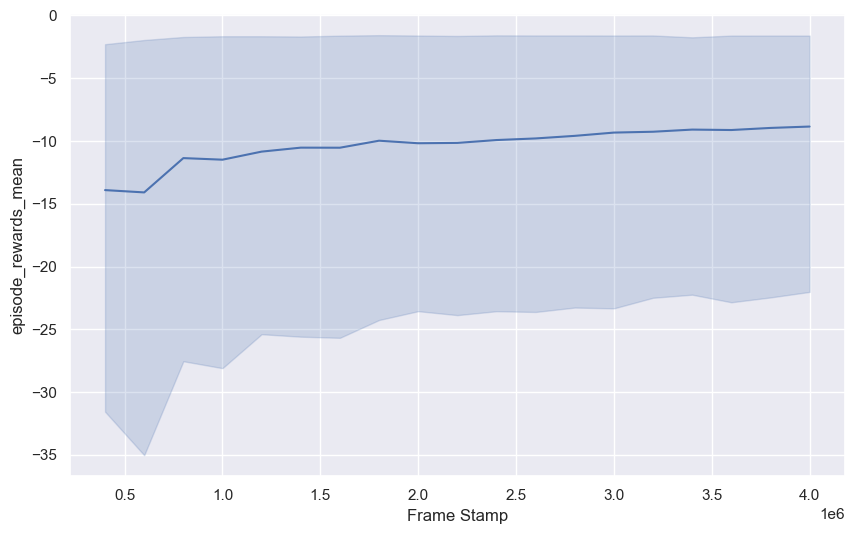

In [9]:
selected_metric = 'episode_rewards_mean'
# Filter for validation episodes
validation_df = df[df['epoch_type'] == 'validation']

# Get the unique sorted frame_stamp values
unique_frames = np.sort(validation_df['frame_stamp'].unique())
N = 1
# Get all frame_stamp values after the first N unique ones
filtered_frames = unique_frames[N:]

# Filter the DataFrame to only include rows with these frame_stamp values
filtered_df = validation_df[validation_df['frame_stamp'].isin(filtered_frames)]

plt.figure(figsize=(10, 6))
sns.lineplot(data=filtered_df, x='frame_stamp', y=selected_metric)
plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')
plt.show()

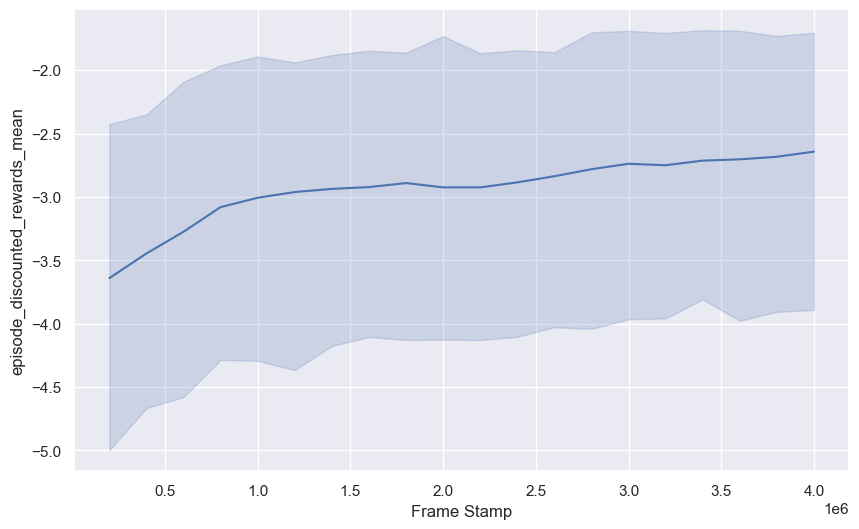

In [10]:

selected_metric = 'episode_discounted_rewards_mean'

validation_df = df[df['epoch_type'] == 'validation']


# Create a new figure for each environment
plt.figure(figsize=(10, 6))
# sns.lineplot(data=df, x='frame_stamp', y=selected_metric, hue='model')
sns.lineplot(data=df, x='frame_stamp', y=selected_metric)

plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')

# Place the legend outside the plot
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Parameters')
plt.show()

In [11]:
### Select data

experiment_columns = [
    'epoch_type', 'frame_stamp',
    'episode_rewards_mean', 'episode_frames_mean', 
    'episode_discounted_rewards_mean',
    'policy_trained_times', 'target_trained_times', 'epoch_time', 
       'seed', 'experiment_name', "sub_experiment_path"
]
hyperparam_columns = [
   col for col in df.columns if "sub_exp_cfg" in col
]

cols_of_interest = experiment_columns + hyperparam_columns

sub_df = df[cols_of_interest]
sub_df = sub_df[sub_df['epoch_type'] == 'validation']
sub_df = sub_df[sub_df['frame_stamp'] == sub_df['frame_stamp'].max()]

sub_df 


,epoch_type,frame_stamp,episode_rewards_mean,episode_frames_mean,episode_discounted_rewards_mean,policy_trained_times,target_trained_times,epoch_time,seed,experiment_name,sub_experiment_path,sub_exp_cfg_agent_params.args_.action_w_noise_amplitude
39,validation,4000000,-35.491324,100.0,-6.075649,NaN,NaN,0 days 00:00:00.369779,0,0000_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0
79,validation,4000000,-3.656703,16.0,-2.594909,NaN,NaN,0 days 00:00:00.341135,0,0001_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0.1
119,validation,4000000,-2.188793,9.0,-1.834154,NaN,NaN,0 days 00:00:00.372281,0,0002_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0.3
159,validation,4000000,-1.453559,6.0,-1.324021,NaN,NaN,0 days 00:00:00.399675,0,0003_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0.6
199,validation,4000000,-1.453559,6.0,-1.324021,NaN,NaN,0 days 00:00:00.381944,0,0004_agent_params.args_.action_w_noise_amplitu...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0.9


In [12]:
# Print the experiment_name of the row with the highest episode_rewards_mean 
print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['sub_experiment_path'].values[0])
# print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['experiment_name'].values[0])
# print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['episode_rewards_mean'].values[0])


D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Apr18-172710_configs\0003_agent_params.args_.action_w_noise_amplitude_0.6\0


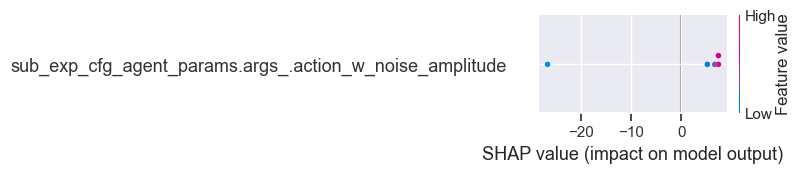

In [13]:
import shap
import xgboost
import pandas as pd


# Define the target metric and hyperparameter columns
target_metric = "episode_rewards_mean"  # Replace with actual metric column name
# Replace with actual hyperparameter column names

# Prepare data
X = sub_df[hyperparam_columns].apply(pd.to_numeric, errors='coerce')
y = sub_df[target_metric].fillna(3 * sub_df[target_metric].min())

# Train an XGBoost model to analyze feature importance
model = xgboost.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X, y)

# SHAP analysis
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Summary plot (feature importance)
shap.summary_plot(shap_values, X)

In [14]:
hyperparam_columns

['sub_exp_cfg_agent_params.args_.action_w_noise_amplitude']

In [15]:
import plotly.express as px

# Define readable names for selected hyperparams
readable_names = {
    hyperparam_columns[0]: "noise",
    hyperparam_columns[1]: "size"
}

# Rename columns in a copy of the dataframe
plot_df = sub_df.rename(columns=readable_names)

# Assign new column names
x_col = "noise"
y_col = "episode_rewards_mean"
facet_col = "size"

# Plot
fig = px.scatter(
    plot_df,
    x=x_col,
    y=y_col,
    color="experiment_name",  # Optional: color by experiment
    facet_col=facet_col,
    title="Episode Rewards vs. Noise Faceted by Size",
    height=600
)

fig.update_layout(showlegend=False)
fig.show()


IndexError: list index out of range